In [53]:
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt

In [54]:
G = 6.67e-11
MASS_SCALE = 2e30
LENGTH_SCALE = 1e10
RATE_OF_MASS_DECREASE = 1e-41

N_SWEEPS = 100
N_INITIALLY = 1000
N = N_INITIALLY
COLLISION_CONST = 1e-30
RELAXATION_CONST = 1e65
ENCOUNTER_PROB_CONST = 1e-9
ERROR_BAR_FOR_RADIUS = 1e30
MAX_R = 100 * LENGTH_SCALE

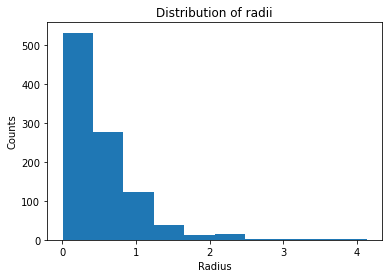

In [55]:
# Initializing the globular cluster of N stars
particles = np.zeros(shape=(N, 7)) # Radius, velocity_r, velocity_theta, velocity_phi, mass, energy, angular_momentum

# Calculating Radii using Plummer model
uniform_for_radii = np.random.uniform(0, 1, size=(N))
uniform_for_radii = uniform_for_radii[uniform_for_radii.argsort()]

temp = []
INVERSE_CDF = []
with open("inverse_CDF_plummer.pickle", "rb") as meow:
    INVERSE_CDF = pickle.load(meow)
temp = INVERSE_CDF[np.array(uniform_for_radii * 10000, dtype=int)]
plt.hist(temp)
plt.title("Distribution of radii")
plt.xlabel("Radius")
plt.ylabel("Counts")
plt.show()
particles[:, 0] = temp * LENGTH_SCALE

# Calculating velocities as uniform random variables
particles[:, 1:4] = np.random.uniform(0, 100, size=(N, 3))
# Calculating mass as uniform between 0 - 5 MASS_SCALE s
particles[:, 4] = np.random.uniform(0.8, 5, size=N) * MASS_SCALE
# Calculating angular_momentum as m*(r x v)
particles[:, 6] = particles[:, 0] * np.linalg.norm(particles[:, 2:4], axis=1) * particles[:, 4]

# Creating a potential variable:
potential = np.zeros(shape=N)

In [56]:
def average_radius():
    global particles
    total_mass = np.sum(particles[:, 4])
    return np.sum(particles[:, 0] * particles[:, 4]) / total_mass

print(average_radius() / LENGTH_SCALE)

0.501277870688229


In [57]:
def potential_calculator():
    global potential, particles, N

    # Sort by radial distance
    particles = particles[particles[:, 0].argsort()]

    total_mass = np.sum(particles[:, 4])
    M_k = total_mass
    # Potential at the last particle is GM/r
    potential[-1] = - G * M_k / particles[-1, 0]
    M_k -= particles[-1, 4]

    for k in range(N-2, -1, -1):
        rk = 1 / particles[k, 0]
        rk1 = 1 / particles[k+1, 0]
        potential[k] = potential[k+1] - (G * M_k * (rk - rk1))
        M_k -= particles[k, 4]
    
    particles[:, 5] = (potential * particles[:, 4]) + (.5 * particles[:, 4] * np.linalg.norm(particles[:, 1:4], axis=1)**2)

# potential_calculator()

# plt.plot(particles[:, 0], particles[:, 5])
# plt.title("Energy of particles with radius")
# plt.xlabel("Radius")
# plt.ylabel("Energy (PE + KE)")
# # plt.plot(particles[:, 0], np.zeros(N))
# plt.show()

# plt.plot(particles[:, 0], potential)
# plt.show()


In [58]:
def calculate_potential_at_radius(r):
    global particles, potential, N
    
    potential_found = 0

    for i in range(N):
        if r < particles[i, 0]:
            rk = 1 / particles[i-1, 0]
            rk1 = 1 / particles[i, 0]
            pot_diff = potential[i] - potential[i-1] 
            potential_found = potential[i-1] + ((rk - (1/r)) * pot_diff / (rk - rk1))
            break
    
    return potential_found

# r = np.array(range(10000)) * LENGTH_SCALE / 10000
# r = np.sort(r)
# pots = [calculate_potential_at_radius(i) for i in r]
# plt.plot(r, pots)
# plt.xscale("log")
# plt.title("Variation of potential with radius")
# plt.xlabel("Radius")
# plt.ylabel("Potential")
# plt.show()

In [59]:
def calculate_time_step(prev_time_step, mass_lost_prev):
    global particles, N, COLLISION_CONST, RELAXATION_CONST

    total_mass = np.sum(particles[:, 4])

    # Calculating relaxation times:
    t_rel_min = 1e100
    for k in range(N):
        vrels_mag = np.linalg.norm(particles[:, 1:4] - particles[k, 1:4])
        vrels_avg = np.mean(vrels_mag)

        mass_rms = np.mean((particles[:, 4] + particles[k, 4])**2)

        t_rel_min = min(t_rel_min, RELAXATION_CONST * vrels_avg ** 3 / mass_rms)
    

    # Calculating collision times
    n_central_stars = min(100, N)
    radius_ms = np.mean(particles[:n_central_stars, 0]**2)
    mass_radius_mean = np.mean(particles[:n_central_stars, 0] * particles[:n_central_stars, 4])

    t_coll = 1 / (COLLISION_CONST * radius_ms * (G * 1e-4 * mass_radius_mean / radius_ms))

    t_se = 0.001 * total_mass * prev_time_step / (mass_lost_prev + 1)
    # print(t_coll, t_rel_min, t_se)
    return min(t_coll, t_rel_min, t_se)

# calculate_time_step(time_step)

In [60]:
def collision_step(time_step):
    global particles, potential, ENCOUNTER_PROB_CONST, N

    collision_count = 0
    for k in range(N):
        if k >= N:
            break
        for k2 in range(N):
            if k2 >= N:
                break
            if k == k2:
                continue

            v_rel = particles[k, 1:4] - particles[k2, 1:4]
            prob_encounter = ENCOUNTER_PROB_CONST * time_step

            if np.random.uniform(0, 1) < prob_encounter:
                # Collide the damn particles
                m1 = particles[k, 4]
                m2 = particles[k2, 4]

                v1 = particles[k, 1]
                v2 = particles[k2, 1]

                particles[k, 4] = (m1 + m2)
                particles[k, 1] = ((m1*v1) + (m2*v2)) / (m1+m2)
                particles[k, 2:4] = np.random.uniform(0, 100, size=2)

                particles[k, 5:] += particles[k2, 5:]

                particles = np.delete(particles, k2, axis=0)
                potential = np.delete(potential, k2, axis=0)

                N -= 1
                collision_count += 1

                break
    print("Collisions in this time step:", collision_count)

# collision_step(1e50)

In [61]:
def stellar_evolution(time_step):
    global particles, RATE_OF_MASS_DECREASE

    mass_to_decrease = RATE_OF_MASS_DECREASE * time_step * particles[:, 4]**2
    particles[:, 4] -= mass_to_decrease

    return np.sum(mass_to_decrease)
# stellar_evolution(1e7) / MASS_SCALE

In [62]:
def new_orbit_calculation():
    global particles, ERROR_BAR_FOR_RADIUS, N
    # plt.plot(particles[:, 0])
    for k in range(N):
        if k % 100 == 0:
            print(k, N)
        E = particles[k, 5]
        m = particles[k, 4]
        L = particles[k, 6]

        # particles[k, 0] = -1

        def eq(E, m, L, r):
            return (2 * E) - (2 * m * calculate_potential_at_radius(r)) - (L**2 / (m * (r + 1)**2))
        
        # print(eq(E, m, L, 1e-3*LENGTH_SCALE))

        # print(particles[-1, 0])
        # rs = np.linspace(0, LENGTH_SCALE, 1000)
        # eq_vals = [eq(E, m, L, r) for r in rs]
        # plt.plot(rs, eq_vals)
        # plt.xscale("log")
        # plt.title("Energy equation for a particle")
        # plt.xlabel("Radius")
        # plt.xlabel("LHS")
        # plt.show()
        
        # Initial guess
        l = 1e-5 * LENGTH_SCALE
        r = 1 * LENGTH_SCALE
        mid = (l + r) / 2

        l_val = eq(E, m, L, l)
        r_val = eq(E, m, L, r)
        mid_val = eq(E, m, L, mid)

        flag = False

        for i in range(1000):
            # print(l, mid, r, l_val, mid_val, r_val)
            if abs(l_val) < ERROR_BAR_FOR_RADIUS:
                flag = True
                particles[k, 0] = l 
                break
            if abs(r_val) < ERROR_BAR_FOR_RADIUS:
                flag = True
                particles[k, 0] = r
                break
            if abs(mid_val) < ERROR_BAR_FOR_RADIUS:
                flag = True
                particles[k, 0] = mid
                break

            if mid_val * l_val < 0:
                r = mid
                mid = (l + r) / 2 
                r_val = mid_val
                mid_val = eq(E, m, L, mid)
                continue
            # elif mid_val * r_val < 0:
            l = mid
            mid = (l + r) / 2 
            l_val = mid_val
            mid_val = eq(E, m, L, mid)
                # continue
            # else:
            #     l = pow(10, -1*np.random.randint(2, 5)) * LENGTH_SCALE
            #     r = 1 * LENGTH_SCALE
            #     mid = (l + r) / 2
            #     l_val = eq(E, m, L, l)
            #     r_val = eq(E, m, L, r)
            #     mid_val = eq(E, m, L, mid)

        if not flag:
            # print("Solution not reached", mid_val, k, mid)
            particles[k, 0] = np.random.uniform(0.1, 1) * LENGTH_SCALE
    
    # plt.plot(particles[:, 0] / LENGTH_SCALE)
    # plt.show()

# new_orbit_calculation()

In [63]:
np.min(particles[:, 0] / LENGTH_SCALE)

0.00100000075185278

In [64]:
average_radius_list = []
particle_radii = []
time_step = 1e100
mass_lost = 0

for time in range(N_SWEEPS):
    print(time)
    average_radius_list.append(average_radius())
    particle_radii.append(particles[:, 0])
    potential_calculator()
    time_step = calculate_time_step(time_step, mass_lost)
    print("Time step:", time_step)

    collision_step(time_step)
    stellar_evolution(time_step)
    new_orbit_calculation()


0
Time step: 77028.17496505451
Collisions in this time step: 72
0 928
100 928
200 928
300 928
400 928
500 928
600 928
700 928
800 928
900 928
1
Time step: 16028.320803160559
Collisions in this time step: 15
0 913
100 913
200 913
300 913
400 913
500 913
600 913
700 913
800 913
900 913
2
Time step: 18965.000294999918
Collisions in this time step: 8
0 905
100 905
200 905
300 905
400 905
500 905
600 905
700 905
800 905
900 905
3
Time step: 19911.714545300503
Collisions in this time step: 22
0 883
100 883
200 883
300 883
400 883
500 883
600 883
700 883
800 883
4
Time step: 18618.354090554076
Collisions in this time step: 12
0 871
100 871
200 871
300 871
400 871
500 871
600 871
700 871
800 871
5
Time step: 19264.84896865993
Collisions in this time step: 17
0 854
100 854
200 854
300 854
400 854
500 854
600 854
700 854
800 854
6
Time step: 15291.01733983362
Collisions in this time step: 10
0 844
100 844
200 844
300 844
400 844
500 844
600 844
700 844
800 844
7
Time step: 14908.175289146413
Col

KeyboardInterrupt: 

[5012778706.882291, 5634138670.459778, 5405238561.267874, 4780942438.95108, 5489866428.717655, 5127819432.815566, 5434814064.614248, 5378008482.787055, 5507005106.444125, 5448920114.245657, 5044052499.3495245, 4736456139.664445, 5460498801.9589615, 5320392175.218229, 4831779335.091152, 5027187236.513172, 4969132305.519003, 5377691077.076568, 5399516444.645856, 4974548680.595886, 4975850410.054113, 5135966442.649208, 4283880774.671898, 5351128740.442618, 5011993192.710885, 5402664677.832748, 4436599279.735404, 4436586117.952337, 5224655092.40425, 5429953958.467003, 4912676000.480103, 5481510622.162759, 5068404964.0773535, 4479165143.315559, 5097611289.407984, 4460361212.373107, 4458485941.410921, 4372449099.595091, 4089688924.614458, 5546256839.971105, 5343499280.281092, 4381846797.809414, 5192023507.640093, 4561199014.480267, 4540373663.340243, 4772161758.556183]


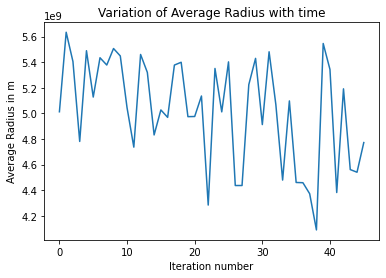

In [65]:
plt.plot(average_radius_list)
print(average_radius_list)
plt.title("Variation of Average Radius with time")
plt.xlabel("Iteration number")
plt.ylabel("Average Radius in m")
# plt.plot(particle_radii[:5][:100])
plt.show()

(45, 1000)


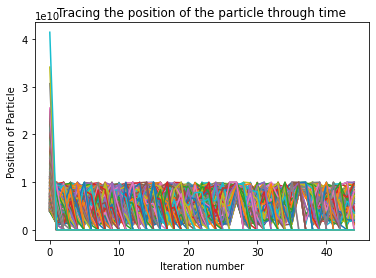

In [95]:
for i in range(45):
    particle_radii[i] = np.concatenate([particle_radii[i], np.zeros(N_INITIALLY - len(particle_radii[i]))])
    # print(len(particle_radii[i]))
plotter = np.array([particle_radii[i] for i in range(45)])
# print(len(particle_radii[0]))
print(plotter.shape)
plt.plot(plotter[:, -500:])

plt.xlabel("Iteration number")
plt.ylabel("Position of Particle")
plt.title("Tracing the position of the particle through time")
plt.show()

In [96]:
for time in range(N_SWEEPS):
    print(time)
    average_radius_list.append(average_radius())
    particle_radii.append(particles[:, 0])
    potential_calculator()
    time_step = calculate_time_step(time_step, mass_lost)
    print("Time step:", time_step)

    collision_step(time_step)
    stellar_evolution(time_step)
    new_orbit_calculation()


0
Time step: 10307.681839547295
Collisions in this time step: 3
0 584
100 584
200 584
300 584
400 584
500 584
1
Time step: 10694.861293041766
Collisions in this time step: 1
0 583
100 583
200 583
300 583
400 583
500 583
2
Time step: 10867.011736372398
Collisions in this time step: 4
0 579
100 579
200 579
300 579
400 579
500 579
3
Time step: 12949.409376875623
Collisions in this time step: 7
0 572
100 572
200 572
300 572
400 572
500 572
4
Time step: 12584.044711057391
Collisions in this time step: 3
0 569
100 569
200 569
300 569
400 569
500 569
5
Time step: 8406.372849761508
Collisions in this time step: 5
0 564
100 564
200 564
300 564
400 564
500 564
6
Time step: 10365.393282246889
Collisions in this time step: 4
0 560
100 560
200 560
300 560
400 560
500 560
7
Time step: 12383.810502982333
Collisions in this time step: 4
0 556
100 556
200 556
300 556
400 556
500 556
8
Time step: 9641.263731358544
Collisions in this time step: 5
0 551
100 551
200 551
300 551
400 551
500 551
9
Time step:

KeyboardInterrupt: 

[5012778706.882291, 5634138670.459778, 5405238561.267874, 4780942438.95108, 5489866428.717655, 5127819432.815566, 5434814064.614248, 5378008482.787055, 5507005106.444125, 5448920114.245657, 5044052499.3495245, 4736456139.664445, 5460498801.9589615, 5320392175.218229, 4831779335.091152, 5027187236.513172, 4969132305.519003, 5377691077.076568, 5399516444.645856, 4974548680.595886, 4975850410.054113, 5135966442.649208, 4283880774.671898, 5351128740.442618, 5011993192.710885, 5402664677.832748, 4436599279.735404, 4436586117.952337, 5224655092.40425, 5429953958.467003, 4912676000.480103, 5481510622.162759, 5068404964.0773535, 4479165143.315559, 5097611289.407984, 4460361212.373107, 4458485941.410921, 4372449099.595091, 4089688924.614458, 5546256839.971105, 5343499280.281092, 4381846797.809414, 5192023507.640093, 4561199014.480267, 4540373663.340243, 4772161758.556183, 5272036534.039599, 4534445798.773946, 3691583029.689121, 5210278510.923682, 5205185375.193912, 5458844323.009836, 5137752757

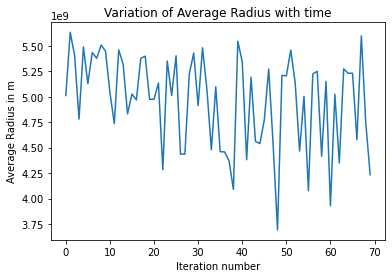

In [97]:
plt.plot(average_radius_list)
print(average_radius_list)
plt.title("Variation of Average Radius with time")
plt.xlabel("Iteration number")
plt.ylabel("Average Radius in m")
# plt.plot(particle_radii[:5][:100])
plt.show()

(70, 1000)


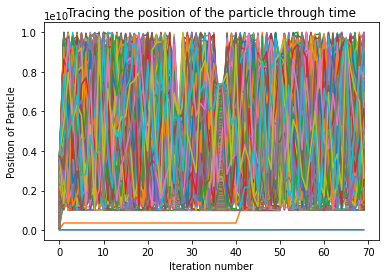

In [99]:
for i in range(len(particle_radii)):
    particle_radii[i] = np.concatenate([particle_radii[i], np.zeros(N_INITIALLY - len(particle_radii[i]))])
    # print(len(particle_radii[i]))
plotter = np.array([particle_radii[i] for i in range(len(particle_radii))])
# print(len(particle_radii[0]))
print(plotter.shape)
plt.plot(plotter[:, :500])

plt.xlabel("Iteration number")
plt.ylabel("Position of Particle")
plt.title("Tracing the position of the particle through time")
plt.show()